Basic imports beforehand

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's grab our cleaned data and put it in a pandas DataFrame. Let's remove the games that were terminated early because one of the players was cheating, as these games aren't fair and shouldn't be considered in our analysis.

In [3]:
data = pd.read_pickle('./Chess_Data.pickle').astype({'Game Type': 'category', 'Result': 'category', 'White ELO': 'uint16', 'Black ELO': 'uint16', 'Time Control': 'string', 'Termination': 'category', 'Moves': 'uint8'})
# drop any game that terminated with 'rules infraction'
data.drop(data.loc[data['Termination'] == 'Rules infraction'].index, inplace=True)

Let's begin by visualizing how many games are won by white, how many games are won by black, and how many games are draws.

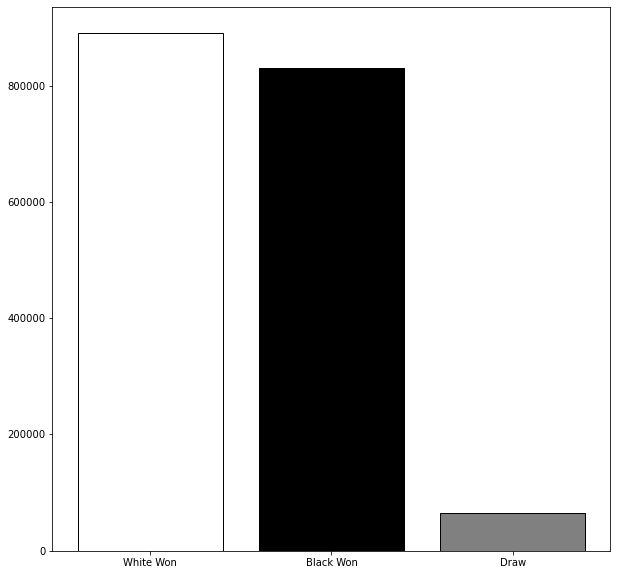

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
ax.bar('White Won', len(data.loc[data['Result'] == '1-0']), color='white', edgecolor='black')
ax.bar('Black Won', len(data.loc[data['Result'] == '0-1']), color='black', edgecolor='black')
ax.bar('Draw', len(data.loc[data['Result'] == '1/2-1/2']), color='gray', edgecolor='black');

That gives us an idea of the overall chances of white winning versus black winning, but lets break it down a bit and see if there is a difference between each type of game (note the difference in y-axis scales, this is because we have different numbers of each game).

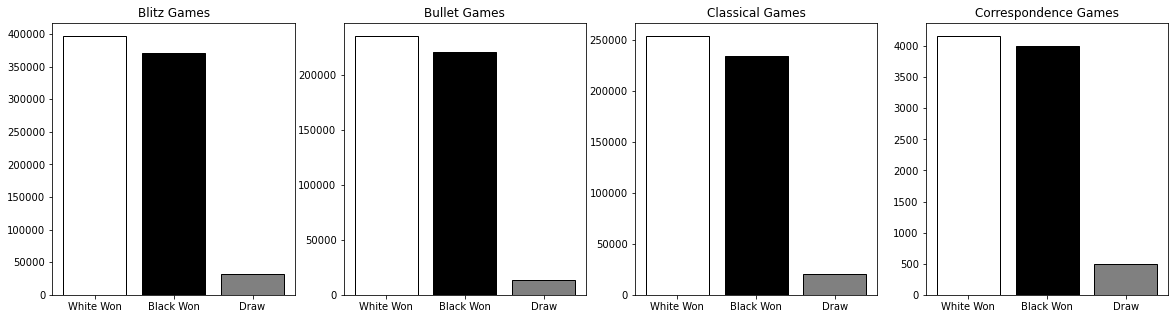

In [5]:
labels = np.unique(data['Game Type'])
whiteWon0 = len(data.loc[(data['Game Type'] == labels[0]) & (data['Result'] == '1-0')])
blackWon0 = len(data.loc[(data['Game Type'] == labels[0]) & (data['Result'] == '0-1')])
draw0 = len(data.loc[(data['Game Type'] == labels[0]) & (data['Result'] == '1/2-1/2')])
whiteWon1 = len(data.loc[(data['Game Type'] == labels[1]) & (data['Result'] == '1-0')])
blackWon1 = len(data.loc[(data['Game Type'] == labels[1]) & (data['Result'] == '0-1')])
draw1 = len(data.loc[(data['Game Type'] == labels[1]) & (data['Result'] == '1/2-1/2')])
whiteWon2 = len(data.loc[(data['Game Type'] == labels[2]) & (data['Result'] == '1-0')])
blackWon2 = len(data.loc[(data['Game Type'] == labels[2]) & (data['Result'] == '0-1')])
draw2 = len(data.loc[(data['Game Type'] == labels[2]) & (data['Result'] == '1/2-1/2')])
whiteWon3 = len(data.loc[(data['Game Type'] == labels[3]) & (data['Result'] == '1-0')])
blackWon3 = len(data.loc[(data['Game Type'] == labels[3]) & (data['Result'] == '0-1')])
draw3 = len(data.loc[(data['Game Type'] == labels[3]) & (data['Result'] == '1/2-1/2')])

fig, axs = plt.subplots(1, 4, figsize=(20,5))
axs[0].bar('White Won', whiteWon0, color='white', edgecolor='black')
axs[0].bar('Black Won', blackWon0, color='black', edgecolor='black')
axs[0].bar('Draw', draw0, color='gray', edgecolor='black')
axs[0].set_title(f'{labels[0]} Games')
axs[1].bar('White Won', whiteWon1, color='white', edgecolor='black')
axs[1].bar('Black Won', blackWon1, color='black', edgecolor='black')
axs[1].bar('Draw', draw1, color='gray', edgecolor='black')
axs[1].set_title(f'{labels[1]} Games')
axs[2].bar('White Won', whiteWon2, color='white', edgecolor='black')
axs[2].bar('Black Won', blackWon2, color='black', edgecolor='black')
axs[2].bar('Draw', draw2, color='gray', edgecolor='black')
axs[2].set_title(f'{labels[2]} Games')
axs[3].bar('White Won', whiteWon3, color='white', edgecolor='black')
axs[3].bar('Black Won', blackWon3, color='black', edgecolor='black')
axs[3].bar('Draw', draw3, color='gray', edgecolor='black')
axs[3].set_title(f'{labels[3]} Games');

What info can we draw from these graphs? It appears that the same general trend still applies to the stratified data. Maybe the ELO of the players makes a difference?

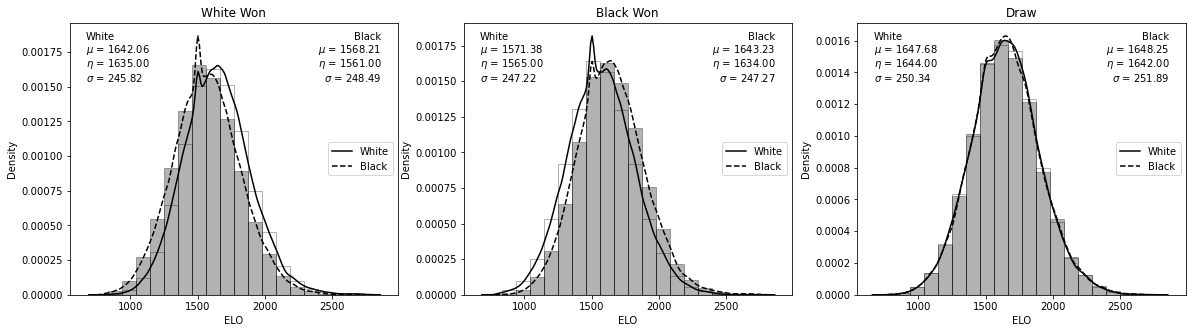

In [42]:
# in the cleaning code, any ELO of '?' was set to 0, we should remove these values because they aren't actually 0s
data.drop(data.loc[(data['White ELO'] == 0) | (data['Black ELO'] == 0)].index, inplace=True)
whiteWonELOs = data.loc[data['Result'] == '1-0', ['Black ELO', 'White ELO']]
blackWonELOs = data.loc[data['Result'] == '0-1', ['Black ELO', 'White ELO']]
drawELOs = data.loc[data['Result'] == '1/2-1/2', ['Black ELO', 'White ELO']]
r = (min(np.min(data['White ELO']), np.min(data['Black ELO'])), max(np.max(data['White ELO']), np.max(data['Black ELO'])))
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

axs[0].hist(whiteWonELOs['White ELO'], bins=20, range=r, density=True, color='white', edgecolor='black', alpha=0.3)
sns.kdeplot(data=whiteWonELOs, x='White ELO', ax=axs[0], label='White', color='black')
axs[0].hist(whiteWonELOs['Black ELO'], bins=20, range=r, density=True, color='black', edgecolor='black', alpha=0.3)
sns.kdeplot(data=whiteWonELOs, x='Black ELO', ax=axs[0], label='Black', color='black', linestyle='dashed')
axs[1].hist(blackWonELOs['White ELO'], bins=20, range=r, density=True, color='white', edgecolor='black', alpha=0.3)
sns.kdeplot(data=blackWonELOs, x='White ELO', ax=axs[1], label='White', color='black')
axs[1].hist(blackWonELOs['Black ELO'], bins=20, range=r, density=True, color='black', edgecolor='black', alpha=0.3)
sns.kdeplot(data=blackWonELOs, x='Black ELO', ax=axs[1], label='Black', color='black', linestyle='dashed')
axs[2].hist(drawELOs['White ELO'], bins=20, range=r, density=True, color='white', edgecolor='black', alpha=0.3)
sns.kdeplot(data=drawELOs, x='White ELO', ax=axs[2], label='White', color='black')
axs[2].hist(drawELOs['Black ELO'], bins=20, range=r, density=True, color='black', edgecolor='black', alpha=0.3)
sns.kdeplot(data=drawELOs, x='Black ELO', ax=axs[2], label='Black', color='black', linestyle='dashed')

axs[0].set_title('White Won')
axs[0].set_xlabel('ELO')
axs[0].text(0.05, 0.95, 'White', transform=axs[0].transAxes, horizontalalignment='left', verticalalignment='center')
axs[0].text(0.05, 0.9, f"$\mu$ = {np.mean(whiteWonELOs['White ELO']):.2f}", transform=axs[0].transAxes,\
     horizontalalignment='left', verticalalignment='center')
axs[0].text(0.05, 0.85, f"$\eta$ = {np.median(whiteWonELOs['White ELO']):.2f}", transform=axs[0].transAxes,\
     horizontalalignment='left', verticalalignment='center')
axs[0].text(0.05, 0.8, f"$\sigma$ = {np.std(whiteWonELOs['White ELO']):.2f}", transform=axs[0].transAxes,\
     horizontalalignment='left', verticalalignment='center')
axs[0].text(0.95, 0.95, 'Black', transform=axs[0].transAxes, horizontalalignment='right', verticalalignment='center')
axs[0].text(0.95, 0.9, f"$\mu$ = {np.mean(whiteWonELOs['Black ELO']):.2f}", transform=axs[0].transAxes,\
     horizontalalignment='right', verticalalignment='center')
axs[0].text(0.95, 0.85, f"$\eta$ = {np.median(whiteWonELOs['Black ELO']):.2f}", transform=axs[0].transAxes,\
     horizontalalignment='right', verticalalignment='center')
axs[0].text(0.95, 0.8, f"$\sigma$ = {np.std(whiteWonELOs['Black ELO']):.2f}", transform=axs[0].transAxes,\
     horizontalalignment='right', verticalalignment='center')
axs[0].legend(loc='center right')

axs[1].set_title('Black Won')
axs[1].set_xlabel('ELO')
axs[1].text(0.05, 0.95, 'White', transform=axs[1].transAxes, horizontalalignment='left', verticalalignment='center')
axs[1].text(0.05, 0.9, f"$\mu$ = {np.mean(blackWonELOs['White ELO']):.2f}", transform=axs[1].transAxes,\
     horizontalalignment='left', verticalalignment='center')
axs[1].text(0.05, 0.85, f"$\eta$ = {np.median(blackWonELOs['White ELO']):.2f}", transform=axs[1].transAxes,\
     horizontalalignment='left', verticalalignment='center')
axs[1].text(0.05, 0.8, f"$\sigma$ = {np.std(blackWonELOs['White ELO']):.2f}", transform=axs[1].transAxes,\
     horizontalalignment='left', verticalalignment='center')
axs[1].text(0.95, 0.95, 'Black', transform=axs[1].transAxes, horizontalalignment='right', verticalalignment='center')
axs[1].text(0.95, 0.9, f"$\mu$ = {np.mean(blackWonELOs['Black ELO']):.2f}", transform=axs[1].transAxes,\
     horizontalalignment='right', verticalalignment='center')
axs[1].text(0.95, 0.85, f"$\eta$ = {np.median(blackWonELOs['Black ELO']):.2f}", transform=axs[1].transAxes,\
     horizontalalignment='right', verticalalignment='center')
axs[1].text(0.95, 0.8, f"$\sigma$ = {np.std(blackWonELOs['Black ELO']):.2f}", transform=axs[1].transAxes,\
     horizontalalignment='right', verticalalignment='center')
axs[1].legend(loc='center right')

axs[2].set_title('Draw')
axs[2].set_xlabel('ELO')
axs[2].text(0.05, 0.95, 'White', transform=axs[2].transAxes, horizontalalignment='left', verticalalignment='center')
axs[2].text(0.05, 0.9, f"$\mu$ = {np.mean(drawELOs['White ELO']):.2f}", transform=axs[2].transAxes,\
     horizontalalignment='left', verticalalignment='center')
axs[2].text(0.05, 0.85, f"$\eta$ = {np.median(drawELOs['White ELO']):.2f}", transform=axs[2].transAxes,\
     horizontalalignment='left', verticalalignment='center')
axs[2].text(0.05, 0.8, f"$\sigma$ = {np.std(drawELOs['White ELO']):.2f}", transform=axs[2].transAxes,\
     horizontalalignment='left', verticalalignment='center')
axs[2].text(0.95, 0.95, 'Black', transform=axs[2].transAxes, horizontalalignment='right', verticalalignment='center')
axs[2].text(0.95, 0.9, f"$\mu$ = {np.mean(drawELOs['Black ELO']):.2f}", transform=axs[2].transAxes,\
     horizontalalignment='right', verticalalignment='center')
axs[2].text(0.95, 0.85, f"$\eta$ = {np.median(drawELOs['Black ELO']):.2f}", transform=axs[2].transAxes,\
     horizontalalignment='right', verticalalignment='center')
axs[2].text(0.95, 0.8, f"$\sigma$ = {np.std(drawELOs['Black ELO']):.2f}", transform=axs[2].transAxes,\
     horizontalalignment='right', verticalalignment='center')
axs[2].legend(loc='center right');

Of course, this method of looking at ELOs erases the paired nature of the data, so let's add a new column with the ELO difference between the two players, measured as `White ELO - Black ELO`. We can then analyze these differences along with who won to try to find a better idea of the correlation.

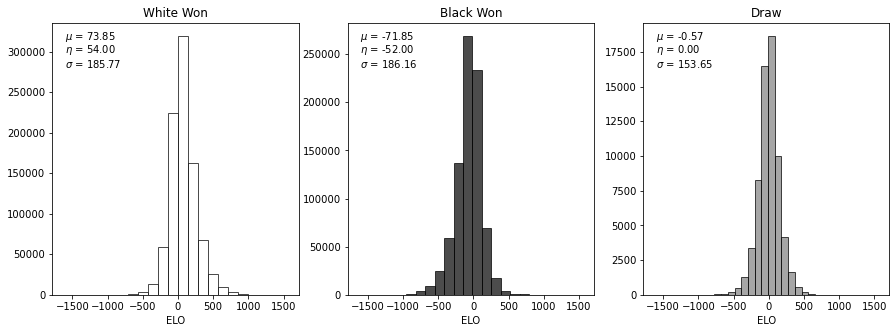

In [72]:
data['ELO Difference'] = (data['White ELO'] - data['Black ELO']).astype('int16')
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
axs[0].hist(data.loc[data['Result'] == '1-0', ['ELO Difference']], bins=20, color='white', edgecolor='black', alpha=0.7)
axs[1].hist(data.loc[data['Result'] == '0-1']['ELO Difference'], bins=20, color='black', edgecolor='black', alpha=0.7)
axs[2].hist(data.loc[data['Result'] == '1/2-1/2']['ELO Difference'], bins=20, color='gray', edgecolor='black', alpha=0.7)
axs[0].set_title('White Won')
axs[0].set_xlabel('ELO')
axs[0].text(0.05, 0.95, f"$\mu$ = {np.mean(data.loc[data['Result'] == '1-0']['ELO Difference']):.2f}",\
     transform=axs[0].transAxes, horizontalalignment='left', verticalalignment='center')
axs[0].text(0.05, 0.9, f"$\eta$ = {np.median(data.loc[data['Result'] == '1-0']['ELO Difference']):.2f}",\
     transform=axs[0].transAxes, horizontalalignment='left', verticalalignment='center')
axs[0].text(0.05, 0.85, f"$\sigma$ = {np.std(data.loc[data['Result'] == '1-0']['ELO Difference']):.2f}",\
     transform=axs[0].transAxes, horizontalalignment='left', verticalalignment='center')
axs[1].set_title('Black Won')
axs[1].set_xlabel('ELO')
axs[1].text(0.05, 0.95, f"$\mu$ = {np.mean(data.loc[data['Result'] == '0-1']['ELO Difference']):.2f}",\
     transform=axs[1].transAxes, horizontalalignment='left', verticalalignment='center')
axs[1].text(0.05, 0.9, f"$\eta$ = {np.median(data.loc[data['Result'] == '0-1']['ELO Difference']):.2f}",\
     transform=axs[1].transAxes, horizontalalignment='left', verticalalignment='center')
axs[1].text(0.05, 0.85, f"$\sigma$ = {np.std(data.loc[data['Result'] == '0-1']['ELO Difference']):.2f}",\
     transform=axs[1].transAxes, horizontalalignment='left', verticalalignment='center')
axs[2].set_title('Draw')
axs[2].text(0.05, 0.95, f"$\mu$ = {np.mean(data.loc[data['Result'] == '1/2-1/2']['ELO Difference']):.2f}",\
     transform=axs[2].transAxes, horizontalalignment='left', verticalalignment='center')
axs[2].text(0.05, 0.9, f"$\eta$ = {np.median(data.loc[data['Result'] == '1/2-1/2']['ELO Difference']):.2f}",\
     transform=axs[2].transAxes, horizontalalignment='left', verticalalignment='center')
axs[2].text(0.05, 0.85, f"$\sigma$ = {np.std(data.loc[data['Result'] == '1/2-1/2']['ELO Difference']):.2f}",\
     transform=axs[2].transAxes, horizontalalignment='left', verticalalignment='center')
axs[2].set_xlabel('ELO');